In [1]:
import os
import re
import pandas
import json
from datetime import datetime
import keras
import numpy

label_data = json.load(open('answer_100.json'))
steps_expr = re.compile(u'(?P<steps>[0-9]+)')
date_expr = "%m-%d"
records = []

for root, dirs, files in os.walk('csv_files/'):
    for f in files:
        base, ext = os.path.splitext(f)
        if ext != ".csv": continue
        csv_path = os.path.join(root, f)
        df = pandas.read_csv(csv_path, header=None)
        date_str = label_data[base]['day']
        steps_str = label_data[base]['steps']
        date_ = datetime.strptime(date_str, date_expr)
        steps = int(steps_expr.search(steps_str).group('steps'))
        label = ("%s%5d" % (date_.strftime('%m%d'), steps)).replace(' ', '0')
        label_digits_ary = numpy.array([int(d) for d in list(label)])
        label_digits_ary = label_digits_ary.reshape(1, *label_digits_ary.shape)
        label_categorical_ary = keras.utils.to_categorical(label_digits_ary, 10)
#         label_categorical_ary = label_categorical_ary.reshape(1, *label_categorical_ary.shape)
        locations = json.loads(df.iloc[:, 1].values[0])
        records.append((
            label, label_digits_ary, label_categorical_ary, date_, steps, locations
        ))                                      
df = pandas.DataFrame(records, columns=['label', 'label digits array', 'label categorical array', 'date', 'steps', 'locations'])

df.head()

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


,label,label digits array,label categorical array,date,steps,locations
0,102213234,"[[1, 0, 2, 2, 1, 3, 2, 3, 4]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-22,13234,"[[4, 166.0, 250.0, 189.0, 275.0], [3, 182.0, 2..."
1,102202461,"[[1, 0, 2, 2, 0, 2, 4, 6, 1]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-22,2461,"[[2, 193.0, 141.0, 230.0, 206.0], [4, 231.0, 1..."
2,102301520,"[[1, 0, 2, 3, 0, 1, 5, 2, 0]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-23,1520,"[[1, 266.0, 181.0, 286.0, 190.0], [5, 266.0, 1..."
3,102804804,"[[1, 0, 2, 8, 0, 4, 8, 0, 4]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,4804,"[[4, 281.0, 189.0, 298.0, 219.0], [8, 296.0, 1..."
4,102805551,"[[1, 0, 2, 8, 0, 5, 5, 5, 1]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,5551,"[[1, 247.0, 168.0, 257.0, 202.0], [5, 271.0, 1..."


In [20]:
calc_centroid = lambda locations: numpy.array([((x[1] + x[3]) / (2. * 544), (x[2] + x[4]) / (2. * 408)) for x in locations])

df['centroids'] = df['locations'].apply(calc_centroid)

df['centroids shape'] = df['centroids'].apply(lambda x: x.shape)
df['ranged centroids'] = df['centroids'].apply(
    lambda x: numpy.pad(x, ((0, 13 - x.shape[0]), (0, 0)), mode='constant', constant_values=0)  if x.shape[0] <= 13 else numpy.empty((13, 2))
)
df['ranged centroids'] = df['ranged centroids'].apply(lambda x: x.reshape(1, *x.shape))
df['ranged centroids shape'] = df['ranged centroids'].apply(lambda x: x.shape)

df['categorical digit'] = df['locations'].apply(lambda x: numpy.array([e[0] for e in x])).apply(lambda x: keras.utils.to_categorical(x, 10))
df['categorical digit shape'] = df['categorical digit'].apply(lambda x: x.shape[0])
df['ranged categorical digit'] = df['categorical digit'].apply(
    lambda x: numpy.pad(x, ((0, 13 - x.shape[0]), (0, 0)), mode='constant', constant_values=0) if x.shape[0] <= 13 else numpy.empty((13,10))
)
df['ranged categorical digit'] = df['ranged categorical digit'].apply(lambda x: x.reshape(1, *x.shape))
df['ranged categorical digit shape'] = df['ranged categorical digit'].apply(lambda x: x.shape)

df['validity'] = df['centroids'].apply(lambda x: x.shape[0] <= 13)

local_df = df.loc[:, ['centroids', 'categorical digit']]
df.head()

,label,label digits array,label categorical array,date,steps,locations,centroids,centroids shape,ranged centroids,ranged centroids shape,categorical digit,categorical digit shape,ranged categorical digit,ranged categorical digit shape,validity
0,102213234,"[[1, 0, 2, 2, 1, 3, 2, 3, 4]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-22,13234,"[[4, 166.0, 250.0, 189.0, 275.0], [3, 182.0, 2...","[[0.32628676470588236, 0.6433823529411765], [0...","(13, 2)","[[[0.32628676470588236, 0.6433823529411765], [...","(1, 13, 2)","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",13,"[[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True
1,102202461,"[[1, 0, 2, 2, 0, 2, 4, 6, 1]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-22,2461,"[[2, 193.0, 141.0, 230.0, 206.0], [4, 231.0, 1...","[[0.38878676470588236, 0.4252450980392157], [0...","(12, 2)","[[[0.38878676470588236, 0.4252450980392157], [...","(1, 13, 2)","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12,"[[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True
2,102301520,"[[1, 0, 2, 3, 0, 1, 5, 2, 0]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-23,1520,"[[1, 266.0, 181.0, 286.0, 190.0], [5, 266.0, 1...","[[0.5073529411764706, 0.45465686274509803], [0...","(11, 2)","[[[0.5073529411764706, 0.45465686274509803], [...","(1, 13, 2)","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",11,"[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True
3,102804804,"[[1, 0, 2, 8, 0, 4, 8, 0, 4]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,4804,"[[4, 281.0, 189.0, 298.0, 219.0], [8, 296.0, 1...","[[0.5321691176470589, 0.5], [0.560661764705882...","(12, 2)","[[[0.5321691176470589, 0.5], [0.56066176470588...","(1, 13, 2)","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",12,"[[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True
4,102805551,"[[1, 0, 2, 8, 0, 5, 5, 5, 1]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,5551,"[[1, 247.0, 168.0, 257.0, 202.0], [5, 271.0, 1...","[[0.4632352941176471, 0.4534313725490196], [0....","(12, 2)","[[[0.4632352941176471, 0.4534313725490196], [0...","(1, 13, 2)","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12,"[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True


In [2]:
from seq2seq.models import SimpleSeq2Seq
import numpy as np
import matplotlib.pylab as plt
import logging
import traceback

# データ作成
x_centroids = numpy.vstack(df[df['validity']]['ranged centroids'].tolist())
x_categorical_digits = numpy.vstack(df[df['validity']]['ranged categorical digit'].tolist())
x = numpy.concatenate((x_centroids, x_categorical_digits), axis=2)

logging.error('centroids: %s', x_centroids.shape)
logging.error('categorical digit: %s', x_categorical_digits.shape)
logging.error('x: %s', x.shape)
y= numpy.vstack(df[df['validity']]['label categorical array'])
logging.error('y: %s', y.shape)

# 3 * 2 階層のDeep Seq2Seq モデルを構築
#model = SimpleSeq2Seq(input_dim=12, hidden_dim=10, output_length=9, output_dim=10, depth=3)
model_test = SimpleSeq2Seq(input_dim=12, hidden_dim=10, output_length=9, output_dim=10, depth=3)

# 学習の設定
#model.compile(loss='mse', optimizer='rmsprop')
model_test.compile(loss='mse', optimizer='rmsprop')

# # 学習
#model.fit(x, y, epochs=10000, batch_size=33, verbose=0)
model_test.fit(x, y, epochs=10000, batch_size=33, verbose=0)

print(model_test.evaluate(x, y, batch_size=x.shape[0]))
# plt.plot(np.arange(0, 0.8, 0.1), [xx[0] for xx in x_test[9]])
# plt.plot(np.arange(0, 0.8, 0.1), [xx[0] for xx in predicted[9]])
# plt.show()

json_string = model_test.to_json()
open(os.path.join('model/seq2_model.json'), 'w').write(json_string)
yaml_string = model_test.to_yaml()
open(os.path.join('model/seq2_model.yaml'), 'w').write(yaml_string)
hdf5_file = "model/seq2_model.hdf5"
model_test.save_weights(hdf5_file)

ImportError: cannot import name '_collect_previous_mask'

In [23]:
# データ作成
x_centroids = numpy.vstack(df[df['validity']]['ranged centroids'].tolist())
x_categorical_digits = numpy.vstack(df[df['validity']]['ranged categorical digit'].tolist())
x = numpy.concatenate((x_centroids, x_categorical_digits), axis=2)

logging.error('centroids: %s', x_centroids.shape)
logging.error('categorical digit: %s', x_categorical_digits.shape)
logging.error('x: %s', x.shape)
y= numpy.vstack(df[df['validity']]['label categorical array'])
logging.error('y: %s', y.shape)

# # 学習したデータで生成
predicted = model_test.predict(x, batch_size=99)

results_df = pandas.DataFrame()
results_df['x digits'] = [[e[0] for e in entry] for entry in df[df['validity']]['locations']]
results_df['x centroids'] = df[df['validity']]['centroids']
print(predicted.shape)
results_df['predicted'] = [''.join([str(e) for e in x]) for x in numpy.argmax(predicted, axis=2).tolist()]
results_df['y'] = df[df['validity']]['label']
results_df.head()

ERROR:root:centroids: (100, 13, 2)
ERROR:root:categorical digit: (100, 13, 10)
ERROR:root:x: (100, 13, 12)
ERROR:root:y: (100, 9, 10)


(100, 9, 10)


,x digits,x centroids,predicted,y
0,"[4, 3, 2, 3, 1, 9, 4, 1, 2, 2, 2, 0, 1]","[[0.32628676470588236, 0.6433823529411765], [0...",102213234,102213234
1,"[2, 4, 6, 1, 1, 0, 2, 2, 1, 1, 5, 7]","[[0.38878676470588236, 0.4252450980392157], [0...",102202461,102202461
2,"[1, 5, 2, 0, 1, 0, 2, 3, 8, 3, 3]","[[0.5073529411764706, 0.45465686274509803], [0...",102301520,102301520
3,"[4, 8, 0, 4, 1, 0, 2, 8, 1, 4, 0, 7]","[[0.5321691176470589, 0.5], [0.560661764705882...",102804804,102804804
4,"[1, 5, 5, 5, 2, 2, 4, 1, 8, 2, 0, 1]","[[0.4632352941176471, 0.4534313725490196], [0....",102805551,102805551


In [22]:
for i in results_df['x centroids']:
    print(i)
    quit()

KeyError: 'x centroids'

In [24]:
pred_text = [''.join([str(e) for e in x]) for x in numpy.argmax(predicted, axis=2).tolist()]
count = 0
for i in pred_text:
    if count == 0:
        i = list(i)
        #pred_ary = list(i)
        pred_month = i[:2]
        pred_day = i[2:4]
        pred_step = i[4:]
        count += 1
    else:
        #pred_ary = numpy.vstack((pred_ary, list(i)))
        i = list(i)
        pred_month += i[:2]
        pred_day += i[2:4]
        pred_step += i[4:]
    
print(np.array(pred_month).shape)
print(np.array(pred_day).shape)
print(np.array(pred_step).shape)

(200,)
(200,)
(500,)


In [25]:
answer_text = df['label']
count = 0
for i in answer_text:
    i = list(i)
    if count == 0:
        answer_month = i[:2]
        answer_day = i[2:4]
        answer_step = i[4:]
        count += 1
    else:
        answer_month += i[:2]
        answer_day += i[2:4]
        answer_step += i[4:]

print(np.array(answer_month).shape)
print(np.array(answer_day).shape)
print(np.array(answer_step).shape)

(200,)
(200,)
(500,)


1.0
0.98
0.984


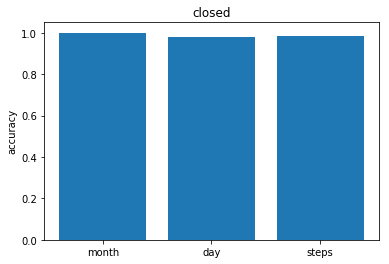

In [26]:
month_result_closed = 0
day_result_closed = 0
step_result_closed = 0
for i, j in zip(pred_month, answer_month):
    if i == j:
        month_result_closed += 1
        
for i, j in zip(pred_day, answer_day):
    if i == j:
        day_result_closed += 1
        
for i, j in zip(pred_step, answer_step):
    if i == j:
        step_result_closed += 1
        
month_result_closed = month_result_closed / len(np.array(pred_month))
day_result_closed = day_result_closed / len(np.array(pred_day))
step_result_closed = step_result_closed / len(np.array(pred_step))

print(month_result_closed)
print(day_result_closed)
print(step_result_closed)

left = (1, 2, 3)
bar_data = np.array([month_result_closed, day_result_closed, step_result_closed])
label = ['month', 'day', 'steps']

plt.bar(left, bar_data, tick_label=label)
plt.ylabel('accuracy')
plt.title('closed')
plt.show()

### オープンなテストを行う
訓練に用いなかったデータをまとめたanswer_open.jsonを作成し、csv_open/の下に訓練に用いなかったAnnotationデータを置く

In [27]:
label_data = json.load(open('answer_open.json'))
steps_expr = re.compile(u'(?P<steps>[0-9]+)')
date_expr = "%m-%d"
records = []

for root, dirs, files in os.walk('csv_open/'):
    for f in files:
        base, ext = os.path.splitext(f)
        if ext != ".csv": continue
        csv_path = os.path.join(root, f)
        df = pandas.read_csv(csv_path, header=None)
        date_str = label_data[base]['day']
        steps_str = label_data[base]['steps']
        date_ = datetime.strptime(date_str, date_expr)
        steps = int(steps_expr.search(steps_str).group('steps'))
        label = ("%s%5d" % (date_.strftime('%m%d'), steps)).replace(' ', '0')
        label_digits_ary = numpy.array([int(d) for d in list(label)])
        label_digits_ary = label_digits_ary.reshape(1, *label_digits_ary.shape)
        label_categorical_ary = keras.utils.to_categorical(label_digits_ary, 10)
#         label_categorical_ary = label_categorical_ary.reshape(1, *label_categorical_ary.shape)
        locations = json.loads(df.iloc[:, 1].values[0])
        records.append((
            label, label_digits_ary, label_categorical_ary, date_, steps, locations
        ))                                      
df = pandas.DataFrame(records, columns=['label', 'label digits array', 'label categorical array', 'date', 'steps', 'locations'])

df.head()

,label,label digits array,label categorical array,date,steps,locations
0,101900037,"[[1, 0, 1, 9, 0, 0, 0, 3, 7]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-19,37,"[[7, 221.0, 247.0, 251.0, 261.0], [3, 228.0, 2..."
1,102213234,"[[1, 0, 2, 2, 1, 3, 2, 3, 4]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-22,13234,"[[9, 194.0, 200.0, 202.0, 219.0], [4, 202.0, 2..."
2,102805861,"[[1, 0, 2, 8, 0, 5, 8, 6, 1]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,5861,"[[1, 272.0, 154.0, 303.0, 187.0], [6, 296.0, 1..."
3,102602441,"[[1, 0, 2, 6, 0, 2, 4, 4, 1]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-26,2441,"[[2, 237.0, 143.0, 260.0, 181.0], [4, 258.0, 1..."
4,102105358,"[[1, 0, 2, 1, 0, 5, 3, 5, 8]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-21,5358,"[[8, 265.0, 205.0, 305.0, 231.0], [5, 261.0, 2..."


In [28]:
calc_centroid = lambda locations: numpy.array([((x[1] + x[3]) / (2. * 544), (x[2] + x[4]) / (2. * 408)) for x in locations])

df['centroids'] = df['locations'].apply(calc_centroid)

df['centroids shape'] = df['centroids'].apply(lambda x: x.shape)
df['ranged centroids'] = df['centroids'].apply(
    lambda x: numpy.pad(x, ((0, 13 - x.shape[0]), (0, 0)), mode='constant', constant_values=0)  if x.shape[0] <= 13 else numpy.empty((13, 2))
)
df['ranged centroids'] = df['ranged centroids'].apply(lambda x: x.reshape(1, *x.shape))
df['ranged centroids shape'] = df['ranged centroids'].apply(lambda x: x.shape)

df['categorical digit'] = df['locations'].apply(lambda x: numpy.array([e[0] for e in x])).apply(lambda x: keras.utils.to_categorical(x, 10))
df['categorical digit shape'] = df['categorical digit'].apply(lambda x: x.shape[0])
df['ranged categorical digit'] = df['categorical digit'].apply(
    lambda x: numpy.pad(x, ((0, 13 - x.shape[0]), (0, 0)), mode='constant', constant_values=0) if x.shape[0] <= 13 else numpy.empty((13,10))
)
df['ranged categorical digit'] = df['ranged categorical digit'].apply(lambda x: x.reshape(1, *x.shape))
df['ranged categorical digit shape'] = df['ranged categorical digit'].apply(lambda x: x.shape)

df['validity'] = df['centroids'].apply(lambda x: x.shape[0] <= 13)

local_df = df.loc[:, ['centroids', 'categorical digit']]
df.head()

,label,label digits array,label categorical array,date,steps,locations,centroids,centroids shape,ranged centroids,ranged centroids shape,categorical digit,categorical digit shape,ranged categorical digit,ranged categorical digit shape,validity
0,101900037,"[[1, 0, 1, 9, 0, 0, 0, 3, 7]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-19,37,"[[7, 221.0, 247.0, 251.0, 261.0], [3, 228.0, 2...","[[0.4338235294117647, 0.6225490196078431], [0....","(9, 2)","[[[0.4338235294117647, 0.6225490196078431], [0...","(1, 13, 2)","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",9,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0...","(1, 13, 10)",True
1,102213234,"[[1, 0, 2, 2, 1, 3, 2, 3, 4]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-22,13234,"[[9, 194.0, 200.0, 202.0, 219.0], [4, 202.0, 2...","[[0.3639705882352941, 0.5134803921568627], [0....","(13, 2)","[[[0.3639705882352941, 0.5134803921568627], [0...","(1, 13, 2)","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",13,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True
2,102805861,"[[1, 0, 2, 8, 0, 5, 8, 6, 1]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,5861,"[[1, 272.0, 154.0, 303.0, 187.0], [6, 296.0, 1...","[[0.5284926470588235, 0.4178921568627451], [0....","(12, 2)","[[[0.5284926470588235, 0.4178921568627451], [0...","(1, 13, 2)","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12,"[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True
3,102602441,"[[1, 0, 2, 6, 0, 2, 4, 4, 1]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-26,2441,"[[2, 237.0, 143.0, 260.0, 181.0], [4, 258.0, 1...","[[0.4568014705882353, 0.39705882352941174], [0...","(12, 2)","[[[0.4568014705882353, 0.39705882352941174], [...","(1, 13, 2)","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12,"[[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True
4,102105358,"[[1, 0, 2, 1, 0, 5, 3, 5, 8]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-21,5358,"[[8, 265.0, 205.0, 305.0, 231.0], [5, 261.0, 2...","[[0.5238970588235294, 0.5343137254901961], [0....","(12, 2)","[[[0.5238970588235294, 0.5343137254901961], [0...","(1, 13, 2)","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",12,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0...","(1, 13, 10)",True


In [29]:
# データ作成
x_centroids = numpy.vstack(df[df['validity']]['ranged centroids'].tolist())
x_categorical_digits = numpy.vstack(df[df['validity']]['ranged categorical digit'].tolist())
x = numpy.concatenate((x_centroids, x_categorical_digits), axis=2)

logging.error('centroids: %s', x_centroids.shape)
logging.error('categorical digit: %s', x_categorical_digits.shape)
logging.error('x: %s', x.shape)
y= numpy.vstack(df[df['validity']]['label categorical array'])
logging.error('y: %s', y.shape)


# # 学習したデータで生成
predicted = model_test.predict(x, batch_size=99)

results_df = pandas.DataFrame()
results_df['x digits'] = [[e[0] for e in entry] for entry in df[df['validity']]['locations']]
results_df['x centroids'] = df[df['validity']]['centroids']
print(predicted.shape)
results_df['predicted'] = [''.join([str(e) for e in x]) for x in numpy.argmax(predicted, axis=2).tolist()]
results_df['y'] = df[df['validity']]['label']
results_df.head(5)

ERROR:root:centroids: (49, 13, 2)
ERROR:root:categorical digit: (49, 13, 10)
ERROR:root:x: (49, 13, 12)
ERROR:root:y: (49, 9, 10)


(49, 9, 10)


,x digits,x centroids,predicted,y
0,"[7, 3, 2, 1, 6, 9, 1, 0, 1]","[[0.4338235294117647, 0.6225490196078431], [0....",101900035,101900037
1,"[9, 4, 1, 2, 2, 2, 0, 1, 4, 3, 2, 3, 1]","[[0.3639705882352941, 0.5134803921568627], [0....",102315121,102213234
2,"[1, 6, 8, 5, 1, 0, 2, 8, 1, 4, 2, 6]","[[0.5284926470588235, 0.4178921568627451], [0....",102306482,102805861
3,"[2, 4, 4, 1, 1, 0, 2, 6, 1, 0, 2, 3]","[[0.4568014705882353, 0.39705882352941174], [0...",102501592,102602441
4,"[8, 5, 3, 5, 1, 0, 2, 1, 1, 4, 4, 2]","[[0.5238970588235294, 0.5343137254901961], [0....",102003550,102105358


In [11]:
count = 0
for i in results_df['x centroids']:
    if count == 5: break
    print(i)
    count += 1

[[0.43382353 0.62254902]
 [0.45496324 0.65686275]
 [0.45588235 0.55882353]
 [0.46231618 0.56985294]
 [0.47886029 0.59681373]
 [0.51194853 0.65073529]
 [0.51838235 0.66544118]
 [0.53952206 0.69607843]
 [0.55055147 0.71323529]]
[[0.36397059 0.51348039]
 [0.37867647 0.5122549 ]
 [0.39338235 0.51593137]
 [0.41176471 0.51960784]
 [0.43841912 0.52328431]
 [0.45404412 0.52573529]
 [0.47702206 0.52573529]
 [0.48713235 0.52696078]
 [0.38051471 0.57230392]
 [0.40441176 0.57230392]
 [0.42647059 0.57843137]
 [0.45128676 0.58333333]
 [0.46783088 0.58088235]]
[[0.52849265 0.41789216]
 [0.57261029 0.44607843]
 [0.59558824 0.48161765]
 [0.63235294 0.50122549]
 [0.70680147 0.46323529]
 [0.69117647 0.45343137]
 [0.66176471 0.42034314]
 [0.64430147 0.41053922]
 [0.60294118 0.37377451]
 [0.58731618 0.36519608]
 [0.56617647 0.34436275]
 [0.54779412 0.32843137]]
[[0.45680147 0.39705882]
 [0.49724265 0.39215686]
 [0.53768382 0.39093137]
 [0.58547794 0.39460784]
 [0.39981618 0.49387255]
 [0.42003676 0.4938725

間違っている要素数を計算するため、yとpredictされたデータの両方を月、日、歩数別の配列に格納する

In [30]:
pred_text = [''.join([str(e) for e in x]) for x in numpy.argmax(predicted, axis=2).tolist()]
count = 0
for i in pred_text:
    if count == 0:
        i = list(i)
        #pred_ary = list(i)
        pred_month = i[:2]
        pred_day = i[2:4]
        pred_step = i[4:]
        count += 1
    else:
        #pred_ary = numpy.vstack((pred_ary, list(i)))
        i = list(i)
        pred_month += i[:2]
        pred_day += i[2:4]
        pred_step += i[4:]
    
print(np.array(pred_month).shape)
print(np.array(pred_day).shape)
print(np.array(pred_step).shape)

(98,)
(98,)
(245,)


In [31]:
answer_text = df['label']
count = 0
for i in answer_text:
    i = list(i)
    if count == 0:
        answer_month = i[:2]
        answer_day = i[2:4]
        answer_step = i[4:]
        count += 1
    else:
        answer_month += i[:2]
        answer_day += i[2:4]
        answer_step += i[4:]

answer_month.pop(-1)
answer_month.pop(-1)
answer_day.pop(-1)
answer_day.pop(-1)
answer_step.pop(-1)
answer_step.pop(-1)
answer_step.pop(-1)
answer_step.pop(-1)
answer_step.pop(-1)
print(np.array(answer_month).shape)
print(np.array(answer_day).shape)
print(np.array(answer_step).shape)

(98,)
(98,)
(245,)


In [32]:
month_result_open = 0
day_result_open = 0
step_result_open = 0
for i, j in zip(pred_month, answer_month):
    if i == j:
        month_result_open += 1
        
for i, j in zip(pred_day, answer_day):
    if i == j:
        day_result_open += 1
        
for i, j in zip(pred_step, answer_step):
    if i == j:
        step_result_open += 1
        
month_result_open = month_result_open / len(np.array(pred_month))
day_result_open = day_result_open / len(np.array(pred_day))
step_result_open = step_result_open / len(np.array(pred_step))

print(month_result_open)
print(day_result_open)
print(step_result_open)

1.0
0.6632653061224489
0.4163265306122449


1.0
0.6632653061224489
0.4163265306122449


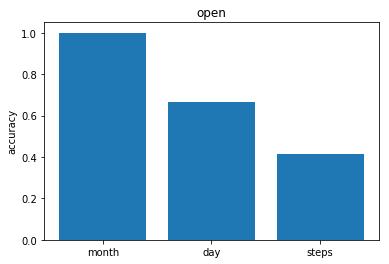

In [33]:
print(month_result_open)
print(day_result_open)
print(step_result_open)

left = (1, 2, 3)
bar_data = np.array([month_result_open, day_result_open, step_result_open])
label = ['month', 'day', 'steps']

plt.bar(left, bar_data, tick_label=label)
plt.ylabel('accuracy')
plt.title('open')
plt.show()

### 正面から見た歩数計画像のみを用いて訓練およびテストを行なってみる
機種はA&Dのものの方が多かったので、それにした

In [42]:
import os
import re
import pandas
import json
from datetime import datetime
import keras
import numpy

label_data = json.load(open('answer_center_AD.json'))
steps_expr = re.compile(u'(?P<steps>[0-9]+)')
date_expr = "%m-%d"
records = []

for root, dirs, files in os.walk('csv_train_ad/'):
    for f in files:
        base, ext = os.path.splitext(f)
        if ext != ".csv": continue
        csv_path = os.path.join(root, f)
        df = pandas.read_csv(csv_path, header=None)
        date_str = label_data[base]['day']
        steps_str = label_data[base]['steps']
        date_ = datetime.strptime(date_str, date_expr)
        steps = int(steps_expr.search(steps_str).group('steps'))
        label = ("%s%5d" % (date_.strftime('%m%d'), steps)).replace(' ', '0')
        label_digits_ary = numpy.array([int(d) for d in list(label)])
        label_digits_ary = label_digits_ary.reshape(1, *label_digits_ary.shape)
        label_categorical_ary = keras.utils.to_categorical(label_digits_ary, 10)
#         label_categorical_ary = label_categorical_ary.reshape(1, *label_categorical_ary.shape)
        locations = json.loads(df.iloc[:, 1].values[0])
        records.append((
            label, label_digits_ary, label_categorical_ary, date_, steps, locations
        ))                                      
df = pandas.DataFrame(records, columns=['label', 'label digits array', 'label categorical array', 'date', 'steps', 'locations'])

df.head()

,label,label digits array,label categorical array,date,steps,locations
0,103005913,"[[1, 0, 3, 0, 0, 5, 9, 1, 3]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-30,5913,"[[5, 306.0, 200.0, 330.0, 243.0], [9, 330.0, 2..."
1,102804804,"[[1, 0, 2, 8, 0, 4, 8, 0, 4]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,4804,"[[4, 281.0, 189.0, 298.0, 219.0], [8, 296.0, 1..."
2,103005925,"[[1, 0, 3, 0, 0, 5, 9, 2, 5]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-30,5925,"[[5, 205.0, 161.0, 229.0, 196.0], [9, 229.0, 1..."
3,103010127,"[[1, 0, 3, 0, 1, 0, 1, 2, 7]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-30,10127,"[[1, 278.0, 175.0, 300.0, 198.0], [0, 290.0, 1..."
4,102602285,"[[1, 0, 2, 6, 0, 2, 2, 8, 5]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-26,2285,"[[2, 186.0, 201.0, 210.0, 239.0], [2, 207.0, 2..."


In [43]:
calc_centroid = lambda locations: numpy.array([((x[1] + x[3]) / (2. * 544), (x[2] + x[4]) / (2. * 408)) for x in locations])

df['centroids'] = df['locations'].apply(calc_centroid)

df['centroids shape'] = df['centroids'].apply(lambda x: x.shape)
df['ranged centroids'] = df['centroids'].apply(
    lambda x: numpy.pad(x, ((0, 13 - x.shape[0]), (0, 0)), mode='constant', constant_values=0)  if x.shape[0] <= 13 else numpy.empty((13, 2))
)
df['ranged centroids'] = df['ranged centroids'].apply(lambda x: x.reshape(1, *x.shape))
df['ranged centroids shape'] = df['ranged centroids'].apply(lambda x: x.shape)

df['categorical digit'] = df['locations'].apply(lambda x: numpy.array([e[0] for e in x])).apply(lambda x: keras.utils.to_categorical(x, 10))
df['categorical digit shape'] = df['categorical digit'].apply(lambda x: x.shape[0])
df['ranged categorical digit'] = df['categorical digit'].apply(
    lambda x: numpy.pad(x, ((0, 13 - x.shape[0]), (0, 0)), mode='constant', constant_values=0) if x.shape[0] <= 13 else numpy.empty((13,10))
)
df['ranged categorical digit'] = df['ranged categorical digit'].apply(lambda x: x.reshape(1, *x.shape))
df['ranged categorical digit shape'] = df['ranged categorical digit'].apply(lambda x: x.shape)

df['validity'] = df['centroids'].apply(lambda x: x.shape[0] <= 13)

local_df = df.loc[:, ['centroids', 'categorical digit']]
df.head()

,label,label digits array,label categorical array,date,steps,locations,centroids,centroids shape,ranged centroids,ranged centroids shape,categorical digit,categorical digit shape,ranged categorical digit,ranged categorical digit shape,validity
0,103005913,"[[1, 0, 3, 0, 0, 5, 9, 1, 3]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-30,5913,"[[5, 306.0, 200.0, 330.0, 243.0], [9, 330.0, 2...","[[0.5845588235294118, 0.5428921568627451], [0....","(11, 2)","[[[0.5845588235294118, 0.5428921568627451], [0...","(1, 13, 2)","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...",11,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True
1,102804804,"[[1, 0, 2, 8, 0, 4, 8, 0, 4]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,4804,"[[4, 281.0, 189.0, 298.0, 219.0], [8, 296.0, 1...","[[0.5321691176470589, 0.5], [0.560661764705882...","(12, 2)","[[[0.5321691176470589, 0.5], [0.56066176470588...","(1, 13, 2)","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",12,"[[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True
2,103005925,"[[1, 0, 3, 0, 0, 5, 9, 2, 5]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-30,5925,"[[5, 205.0, 161.0, 229.0, 196.0], [9, 229.0, 1...","[[0.39889705882352944, 0.4375], [0.43933823529...","(11, 2)","[[[0.39889705882352944, 0.4375], [0.4393382352...","(1, 13, 2)","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...",11,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True
3,103010127,"[[1, 0, 3, 0, 1, 0, 1, 2, 7]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-30,10127,"[[1, 278.0, 175.0, 300.0, 198.0], [0, 290.0, 1...","[[0.53125, 0.4571078431372549], [0.55330882352...","(13, 2)","[[[0.53125, 0.4571078431372549], [0.5533088235...","(1, 13, 2)","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",13,"[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True
4,102602285,"[[1, 0, 2, 6, 0, 2, 2, 8, 5]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-26,2285,"[[2, 186.0, 201.0, 210.0, 239.0], [2, 207.0, 2...","[[0.3639705882352941, 0.5392156862745098], [0....","(12, 2)","[[[0.3639705882352941, 0.5392156862745098], [0...","(1, 13, 2)","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12,"[[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True


In [44]:
from seq2seq.models import SimpleSeq2Seq
import numpy as np
import matplotlib.pylab as plt
import logging
import traceback

# データ作成
x_centroids = numpy.vstack(df[df['validity']]['ranged centroids'].tolist())
x_categorical_digits = numpy.vstack(df[df['validity']]['ranged categorical digit'].tolist())
x = numpy.concatenate((x_centroids, x_categorical_digits), axis=2)

logging.error('centroids: %s', x_centroids.shape)
logging.error('categorical digit: %s', x_categorical_digits.shape)
logging.error('x: %s', x.shape)
y= numpy.vstack(df[df['validity']]['label categorical array'])
logging.error('y: %s', y.shape)

# 3 * 2 階層のDeep Seq2Seq モデルを構築
model_center_AD = SimpleSeq2Seq(input_dim=12, hidden_dim=10, output_length=9, output_dim=10, depth=3)

# 学習の設定
model_center_AD.compile(loss='mse', optimizer='rmsprop')

# # 学習
model_center_AD.fit(x, y, epochs=10000, batch_size=33, verbose=0)

print(model_test.evaluate(x, y, batch_size=x.shape[0]))
# plt.plot(np.arange(0, 0.8, 0.1), [xx[0] for xx in x_test[9]])
# plt.plot(np.arange(0, 0.8, 0.1), [xx[0] for xx in predicted[9]])
# plt.show()

json_string = model_center_AD.to_json()
open(os.path.join('model/seq2_model_center_AD.json'), 'w').write(json_string)
yaml_string = model_center_AD.to_yaml()
open(os.path.join('model/seq2_model_center_AD.yaml'), 'w').write(yaml_string)
hdf5_file = "model/seq2_model_center_AD.hdf5"
model_center_AD.save_weights(hdf5_file)

ERROR:root:centroids: (68, 13, 2)
ERROR:root:categorical digit: (68, 13, 10)
ERROR:root:x: (68, 13, 12)
ERROR:root:y: (68, 9, 10)


68/68 [==============================] - 0s 507us/step
0.035331714898347855


In [45]:
label_data = json.load(open('answer_center_AD_test.json'))
steps_expr = re.compile(u'(?P<steps>[0-9]+)')
date_expr = "%m-%d"
records = []

for root, dirs, files in os.walk('csv_test_ad/'):
    for f in files:
        base, ext = os.path.splitext(f)
        if ext != ".csv": continue
        csv_path = os.path.join(root, f)
        df = pandas.read_csv(csv_path, header=None)
        date_str = label_data[base]['day']
        steps_str = label_data[base]['steps']
        date_ = datetime.strptime(date_str, date_expr)
        steps = int(steps_expr.search(steps_str).group('steps'))
        label = ("%s%5d" % (date_.strftime('%m%d'), steps)).replace(' ', '0')
        label_digits_ary = numpy.array([int(d) for d in list(label)])
        label_digits_ary = label_digits_ary.reshape(1, *label_digits_ary.shape)
        label_categorical_ary = keras.utils.to_categorical(label_digits_ary, 10)
#         label_categorical_ary = label_categorical_ary.reshape(1, *label_categorical_ary.shape)
        locations = json.loads(df.iloc[:, 1].values[0])
        records.append((
            label, label_digits_ary, label_categorical_ary, date_, steps, locations
        ))                                      
df = pandas.DataFrame(records, columns=['label', 'label digits array', 'label categorical array', 'date', 'steps', 'locations'])

df.head()

,label,label digits array,label categorical array,date,steps,locations
0,102806368,"[[1, 0, 2, 8, 0, 6, 3, 6, 8]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,6368,"[[8, 288.0, 192.0, 312.0, 225.0], [6, 308.0, 1..."
1,102802341,"[[1, 0, 2, 8, 0, 2, 3, 4, 1]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,2341,"[[2, 204.0, 207.0, 227.0, 248.0], [3, 229.0, 2..."
2,102801051,"[[1, 0, 2, 8, 0, 1, 0, 5, 1]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,1051,"[[1, 255.0, 271.0, 265.0, 297.0], [0, 264.0, 2..."
3,102805822,"[[1, 0, 2, 8, 0, 5, 8, 2, 2]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,5822,"[[6, 233.0, 120.0, 252.0, 152.0], [2, 249.0, 1..."
4,103005925,"[[1, 0, 3, 0, 0, 5, 9, 2, 5]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-30,5925,"[[5, 182.0, 291.0, 207.0, 327.0], [9, 205.0, 2..."


In [46]:
calc_centroid = lambda locations: numpy.array([((x[1] + x[3]) / (2. * 544), (x[2] + x[4]) / (2. * 408)) for x in locations])

df['centroids'] = df['locations'].apply(calc_centroid)

df['centroids shape'] = df['centroids'].apply(lambda x: x.shape)
df['ranged centroids'] = df['centroids'].apply(
    lambda x: numpy.pad(x, ((0, 13 - x.shape[0]), (0, 0)), mode='constant', constant_values=0)  if x.shape[0] <= 13 else numpy.empty((13, 2))
)
df['ranged centroids'] = df['ranged centroids'].apply(lambda x: x.reshape(1, *x.shape))
df['ranged centroids shape'] = df['ranged centroids'].apply(lambda x: x.shape)

df['categorical digit'] = df['locations'].apply(lambda x: numpy.array([e[0] for e in x])).apply(lambda x: keras.utils.to_categorical(x, 10))
df['categorical digit shape'] = df['categorical digit'].apply(lambda x: x.shape[0])
df['ranged categorical digit'] = df['categorical digit'].apply(
    lambda x: numpy.pad(x, ((0, 13 - x.shape[0]), (0, 0)), mode='constant', constant_values=0) if x.shape[0] <= 13 else numpy.empty((13,10))
)
df['ranged categorical digit'] = df['ranged categorical digit'].apply(lambda x: x.reshape(1, *x.shape))
df['ranged categorical digit shape'] = df['ranged categorical digit'].apply(lambda x: x.shape)

df['validity'] = df['centroids'].apply(lambda x: x.shape[0] <= 13)

local_df = df.loc[:, ['centroids', 'categorical digit']]
df.head()

,label,label digits array,label categorical array,date,steps,locations,centroids,centroids shape,ranged centroids,ranged centroids shape,categorical digit,categorical digit shape,ranged categorical digit,ranged categorical digit shape,validity
0,102806368,"[[1, 0, 2, 8, 0, 6, 3, 6, 8]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,6368,"[[8, 288.0, 192.0, 312.0, 225.0], [6, 308.0, 1...","[[0.5514705882352942, 0.5110294117647058], [0....","(12, 2)","[[[0.5514705882352942, 0.5110294117647058], [0...","(1, 13, 2)","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",12,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0...","(1, 13, 10)",True
1,102802341,"[[1, 0, 2, 8, 0, 2, 3, 4, 1]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,2341,"[[2, 204.0, 207.0, 227.0, 248.0], [3, 229.0, 2...","[[0.3961397058823529, 0.5575980392156863], [0....","(11, 2)","[[[0.3961397058823529, 0.5575980392156863], [0...","(1, 13, 2)","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",11,"[[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True
2,102801051,"[[1, 0, 2, 8, 0, 1, 0, 5, 1]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,1051,"[[1, 255.0, 271.0, 265.0, 297.0], [0, 264.0, 2...","[[0.47794117647058826, 0.696078431372549], [0....","(11, 2)","[[[0.47794117647058826, 0.696078431372549], [0...","(1, 13, 2)","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",11,"[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True
3,102805822,"[[1, 0, 2, 8, 0, 5, 8, 2, 2]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-28,5822,"[[6, 233.0, 120.0, 252.0, 152.0], [2, 249.0, 1...","[[0.44577205882352944, 0.3333333333333333], [0...","(12, 2)","[[[0.44577205882352944, 0.3333333333333333], [...","(1, 13, 2)","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...",12,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0...","(1, 13, 10)",True
4,103005925,"[[1, 0, 3, 0, 0, 5, 9, 2, 5]]","[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1900-10-30,5925,"[[5, 182.0, 291.0, 207.0, 327.0], [9, 205.0, 2...","[[0.35753676470588236, 0.7573529411764706], [0...","(11, 2)","[[[0.35753676470588236, 0.7573529411764706], [...","(1, 13, 2)","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...",11,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0...","(1, 13, 10)",True


In [47]:
# データ作成
x_centroids = numpy.vstack(df[df['validity']]['ranged centroids'].tolist())
x_categorical_digits = numpy.vstack(df[df['validity']]['ranged categorical digit'].tolist())
x = numpy.concatenate((x_centroids, x_categorical_digits), axis=2)

logging.error('centroids: %s', x_centroids.shape)
logging.error('categorical digit: %s', x_categorical_digits.shape)
logging.error('x: %s', x.shape)
y= numpy.vstack(df[df['validity']]['label categorical array'])
logging.error('y: %s', y.shape)


# # 学習したデータで生成
predicted = model_center_AD.predict(x, batch_size=99)

results_df = pandas.DataFrame()
results_df['x digits'] = [[e[0] for e in entry] for entry in df[df['validity']]['locations']]
results_df['x centroids'] = df[df['validity']]['centroids']
print(predicted.shape)
results_df['predicted'] = [''.join([str(e) for e in x]) for x in numpy.argmax(predicted, axis=2).tolist()]
results_df['y'] = df[df['validity']]['label']
results_df.head(10)

ERROR:root:centroids: (10, 13, 2)
ERROR:root:categorical digit: (10, 13, 10)
ERROR:root:x: (10, 13, 12)
ERROR:root:y: (10, 9, 10)


(10, 9, 10)


,x digits,x centroids,predicted,y
0,"[8, 6, 3, 6, 8, 3, 4, 1, 8, 2, 0, 1]","[[0.5514705882352942, 0.5110294117647058], [0....",102804551,102806368
1,"[2, 3, 4, 1, 1, 0, 2, 8, 9, 4, 6]","[[0.3961397058823529, 0.5575980392156863], [0....",102802135,102802341
2,"[1, 0, 5, 1, 1, 0, 2, 8, 9, 1, 6]","[[0.47794117647058826, 0.696078431372549], [0....",102801256,102801051
3,"[6, 2, 4, 1, 8, 2, 0, 1, 2, 2, 8, 5]","[[0.44577205882352944, 0.3333333333333333], [0...",102805822,102805822
4,"[5, 9, 2, 5, 1, 0, 3, 0, 4, 3, 3]","[[0.35753676470588236, 0.7573529411764706], [0...",103005925,103005925
5,"[4, 6, 5, 8, 1, 0, 2, 8, 1, 4, 0, 2]","[[0.6580882352941176, 0.4178921568627451], [0....",102804529,102804658
6,"[4, 1, 7, 1, 1, 0, 2, 8, 1, 3, 5, 4]","[[0.5220588235294118, 0.38235294117647056], [0...",102804756,102804171
7,"[4, 3, 1, 2, 1, 0, 2, 9, 1, 8, 4, 5]","[[0.5165441176470589, 0.5919117647058824], [0....",102904355,102904312
8,"[2, 2, 7, 5, 1, 0, 2, 6, 1, 0, 1, 8]","[[0.37683823529411764, 0.4730392156862745], [0...",102602215,102602275
9,"[4, 3, 5, 4, 1, 0, 2, 9, 1, 8, 5, 0]","[[0.5055147058823529, 0.4375], [0.549632352941...",102806335,102904354


In [48]:
pred_text = [''.join([str(e) for e in x]) for x in numpy.argmax(predicted, axis=2).tolist()]
count = 0
for i in pred_text:
    if count == 0:
        i = list(i)
        #pred_ary = list(i)
        pred_month = i[:2]
        pred_day = i[2:4]
        pred_step = i[4:]
        count += 1
    else:
        #pred_ary = numpy.vstack((pred_ary, list(i)))
        i = list(i)
        pred_month += i[:2]
        pred_day += i[2:4]
        pred_step += i[4:]
    
print(np.array(pred_month).shape)
print(np.array(pred_day).shape)
print(np.array(pred_step).shape)

(20,)
(20,)
(50,)


In [49]:
answer_text = df['label']
count = 0
for i in answer_text:
    i = list(i)
    if count == 0:
        answer_month = i[:2]
        answer_day = i[2:4]
        answer_step = i[4:]
        count += 1
    else:
        answer_month += i[:2]
        answer_day += i[2:4]
        answer_step += i[4:]

print(np.array(answer_month).shape)
print(np.array(answer_day).shape)
print(np.array(answer_step).shape)

(20,)
(20,)
(50,)


1.0
0.95
0.58


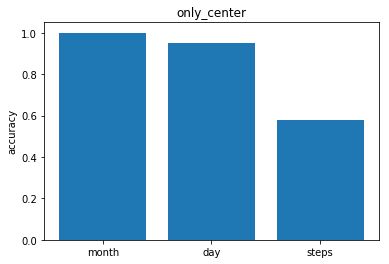

In [50]:
month_result_ad = 0
day_result_ad = 0
step_result_ad = 0
for i, j in zip(pred_month, answer_month):
    if i == j:
        month_result_ad += 1
        
for i, j in zip(pred_day, answer_day):
    if i == j:
        day_result_ad += 1
        
for i, j in zip(pred_step, answer_step):
    if i == j:
        step_result_ad += 1
        
month_result_ad = month_result_ad / len(np.array(pred_month))
day_result_ad = day_result_ad / len(np.array(pred_day))
step_result_ad = step_result_ad / len(np.array(pred_step))

print(month_result_ad)
print(day_result_ad)
print(step_result_ad)

left = (1, 2, 3) 
bar_data = np.array([month_result_ad, day_result_ad, step_result_ad])
label = ['month', 'day', 'steps']

plt.bar(left, bar_data, tick_label=label)
plt.ylabel('accuracy')
plt.title('only_center')
plt.show()

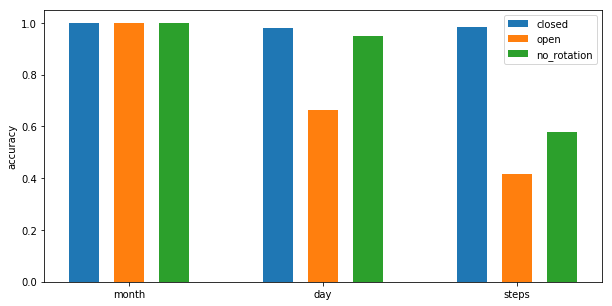

In [55]:
left1 = (1, 2.3, 3.6)
left2 = (1.3, 2.6, 3.9)
left3 = (1.6, 2.9, 4.2)

bar1 = np.array([month_result_closed, day_result_closed, step_result_closed])
bar2 = np.array([month_result_open, day_result_open, step_result_open])
bar3 = np.array([month_result_ad, day_result_ad, step_result_ad])
label1 = 'closed'
label2 = 'open'
label3 = 'no_rotation'

plt.figure(figsize=(10,5))

plt.bar(left1, bar1, width=0.2, label=label1)
plt.bar(left2, bar2, width=0.2, label=label2)
plt.bar(left3, bar3, width=0.2, label=label3)
plt.ylabel('accuracy')
plt.legend()
plt.xticks([1.3, 2.6, 3.9], ['month','day','steps'])
plt.show()

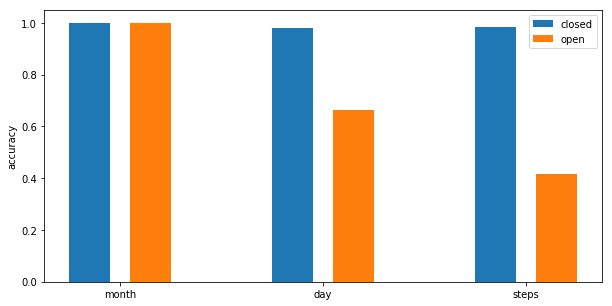

In [59]:
left1 = (1, 2, 3)
left2 = (1.3, 2.3, 3.3)
#left3 = (1.6, 2.9, 4.2)

bar1 = np.array([month_result_closed, day_result_closed, step_result_closed])
bar2 = np.array([month_result_open, day_result_open, step_result_open])
#bar3 = np.array([month_result_ad, day_result_ad, step_result_ad])
label1 = 'closed'
label2 = 'open'
#label3 = 'no_rotation'

plt.figure(figsize=(10,5))

plt.bar(left1, bar1, width=0.2, label=label1)
plt.bar(left2, bar2, width=0.2, label=label2)
#plt.bar(left3, bar3, width=0.2, label=label3)
plt.ylabel('accuracy')
plt.legend()
plt.xticks([1.15, 2.15, 3.15], ['month','day','steps'])
plt.show()

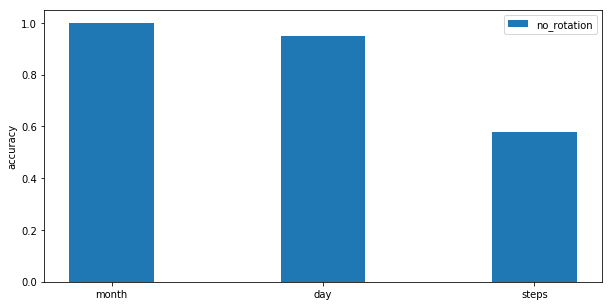

In [62]:
left1 = (1, 1.5, 2)
#left2 = (1.3, 2.3, 3.3)
#left3 = (1.6, 2.9, 4.2)

#bar1 = np.array([month_result_closed, day_result_closed, step_result_closed])
#bar2 = np.array([month_result_open, day_result_open, step_result_open])
bar3 = np.array([month_result_ad, day_result_ad, step_result_ad])
#label1 = 'closed'
#label2 = 'open'
label3 = 'no_rotation'

plt.figure(figsize=(10,5))

#plt.bar(left1, bar1, width=0.2, label=label1)
#plt.bar(left2, bar2, width=0.2, label=label2)
plt.bar(left1, bar3, width=0.2, label=label3)
plt.ylabel('accuracy')
plt.legend()
plt.xticks([1, 1.5, 2], ['month','day','steps'])
plt.show()